I decided to go the route of converting images into numpy arrays for training and testing as opposed to using the Keras built-in ImageDataGenerator and FlowFromDirectory (opting instead for a single file of raw image data and discrete file of labels).  In this notebook, I will be building a CNN from scratch an leveraing the different data pipeline methodology

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import PIL

seed = 16
np.random.seed(seed)

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization

import keras.utils
from keras import backend as K
K.set_image_dim_ordering('tf')

from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=2)

c:\users\garrick\anaconda3\envs\tensorflow\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#check using system GPU for processing and declaring system/GPU parameters

from tensorflow.python.client import device_lib
import tensorflow as tf
os.environ["CUDA_VISIBLE_DEVICES"]="0" #for training on gpu
print(device_lib.list_local_devices())

# configure tensorflow before fitting model
tf_config = tf.ConfigProto()
tf_config.gpu_options.per_process_gpu_memory_fraction = 0.99
sess = tf.Session(config=tf_config)


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12137169276187359085
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1493781708
locality {
  bus_id: 1
}
incarnation: 11196391039614899935
physical_device_desc: "device: 0, name: GeForce GTX 860M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [3]:
# changing directory to access data (as numpy arrays)
os.chdir('C:\\Users\\Garrick\\Documents\\Springboard\\Capstone Project 2\\datasets')

In [4]:
# define functions to load data

def load_array(fname):
    return np.load(open(fname,'rb'))

In [5]:
# load in labels and data (as tensors)

train_labels=load_array('train_labels.npy')
valid_labels=load_array('valid_labels.npy')

In [6]:
train_tensor=load_array('train_dataset.npy')

In [7]:
def Normalize_Input(X):
    minimum=0
    maximum=255
    X-minimum/(maximum-minimum)
    return X  

In [8]:
train_tensor=Normalize_Input(train_tensor)

In [10]:
valid_tensor=load_array('valid_dataset.npy')

In [11]:
valid_tensor=Normalize_Input(valid_tensor)

In [12]:
# feeding the training data through an Image Augmentation process (including resizing and shifting tolerance)

num_classes = 120
batch_size = 12
input_shape = (224, 224, 3)

datagen = ImageDataGenerator(rotation_range=15, width_shift_range=0.1, height_shift_range=0.1, 
                             zoom_range=0.1, horizontal_flip=True)


# note to self... perhaps the imagedatagenerator parameters I had before were root cause of low accuracy...

train_generator = datagen.flow(x=train_tensor, y=train_labels, batch_size=batch_size)
validation_generator = datagen.flow(x=valid_tensor, y=valid_labels, batch_size=batch_size)

In [13]:
# fit the ImageDataGenerator 
datagen.fit(train_tensor)

In [43]:
wide_model_slow_learn = Sequential()

wide_model_slow_learn.add(BatchNormalization(input_shape=input_shape))
wide_model_slow_learn.add(Conv2D(64, (3, 3), strides=1, input_shape=input_shape, padding='valid', activation='relu', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_slow_learn.add(BatchNormalization())

wide_model_slow_learn.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_slow_learn.add(BatchNormalization())

wide_model_slow_learn.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_slow_learn.add(BatchNormalization())

wide_model_slow_learn.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_slow_learn.add(BatchNormalization())

wide_model_slow_learn.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_slow_learn.add(BatchNormalization())

wide_model_slow_learn.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_slow_learn.add(BatchNormalization())

wide_model_slow_learn.add(Dense(2048, activation='relu', kernel_constraint=maxnorm(3)))
wide_model_slow_learn.add(Dropout(0.2))
wide_model_slow_learn.add(GlobalAveragePooling2D())

wide_model_slow_learn.add(Dense(num_classes, activation='softmax'))
    
# Compile model

adam_op = Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
wide_model_slow_learn.compile(loss='sparse_categorical_crossentropy', optimizer=adam_op, metrics=['accuracy']) 
#loss changed to sparse for new label data
print(wide_model_slow_learn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_7 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 111, 111, 64)      256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 54, 54, 64)        256       
__________

In [15]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch_v3.hdf5', 
                               verbose=1, save_best_only=True)

In [17]:
wide_model_slow_learn.fit_generator(train_generator, validation_data=validation_generator,
                         steps_per_epoch=800, epochs=10, callbacks=[checkpointer, early_stopping])

Epoch 1/10
800/800 [==============================] - 196s 245ms/step - loss: 4.7750 - acc: 0.0128 - val_loss: 4.7370 - val_acc: 0.0246

Epoch 00001: val_loss improved from inf to 4.73699, saving model to saved_models/weights.bestaugmented.from_scratch_v3.hdf5
Epoch 2/10
800/800 [==============================] - 183s 229ms/step - loss: 4.7077 - acc: 0.0199 - val_loss: 4.6666 - val_acc: 0.0275

Epoch 00002: val_loss improved from 4.73699 to 4.66660, saving model to saved_models/weights.bestaugmented.from_scratch_v3.hdf5
Epoch 3/10
800/800 [==============================] - 184s 230ms/step - loss: 4.6375 - acc: 0.0264 - val_loss: 4.6027 - val_acc: 0.0296

Epoch 00003: val_loss improved from 4.66660 to 4.60269, saving model to saved_models/weights.bestaugmented.from_scratch_v3.hdf5
Epoch 4/10
800/800 [==============================] - 183s 229ms/step - loss: 4.5706 - acc: 0.0283 - val_loss: 4.5389 - val_acc: 0.0346

Epoch 00004: val_loss improved from 4.60269 to 4.53886, saving model to 

In [13]:
# try faster learning rate, see if we can speed up the improvement

wide_model_fast_learn = Sequential()

wide_model_fast_learn.add(BatchNormalization(input_shape=input_shape))
wide_model_fast_learn.add(Conv2D(64, (3, 3), strides=1, input_shape=input_shape, padding='valid', activation='relu', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_fast_learn.add(BatchNormalization())

wide_model_fast_learn.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_fast_learn.add(BatchNormalization())

wide_model_fast_learn.add(Conv2D(64, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_fast_learn.add(BatchNormalization())

wide_model_fast_learn.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_fast_learn.add(BatchNormalization())

wide_model_fast_learn.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_fast_learn.add(BatchNormalization())

wide_model_fast_learn.add(Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(MaxPooling2D(pool_size=(2, 2)))
wide_model_fast_learn.add(BatchNormalization())

wide_model_fast_learn.add(Dense(2048, activation='relu', kernel_constraint=maxnorm(3)))
wide_model_fast_learn.add(Dropout(0.2))
wide_model_fast_learn.add(GlobalAveragePooling2D())

wide_model_fast_learn.add(Dense(num_classes, activation='softmax'))
    
# Compile model

adam_op = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
wide_model_fast_learn.compile(loss='sparse_categorical_crossentropy', optimizer=adam_op, metrics=['accuracy']) 
#loss changed to sparse for new label data
print(wide_model_fast_learn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 111, 111, 64)      256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 54, 54, 64)        256       
__________

In [16]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5', 
                               verbose=1, save_best_only=True)

history_wmfl = wide_model_fast_learn.fit_generator(train_generator, validation_data=validation_generator,
                         steps_per_epoch=800, epochs=20, callbacks=[checkpointer, early_stopping])

Epoch 1/20
800/800 [==============================] - 202s 253ms/step - loss: 4.4684 - acc: 0.0348 - val_loss: 4.3635 - val_acc: 0.0438

Epoch 00001: val_loss improved from inf to 4.36345, saving model to saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5
Epoch 2/20
800/800 [==============================] - 184s 230ms/step - loss: 4.1956 - acc: 0.0567 - val_loss: 4.2798 - val_acc: 0.0542

Epoch 00002: val_loss improved from 4.36345 to 4.27984, saving model to saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5
Epoch 3/20
800/800 [==============================] - 187s 233ms/step - loss: 4.0627 - acc: 0.0654 - val_loss: 4.1614 - val_acc: 0.0592

Epoch 00003: val_loss improved from 4.27984 to 4.16142, saving model to saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5
Epoch 4/20
800/800 [==============================] - 184s 230ms/step - loss: 3.9643 - acc: 0.0843 - val_loss: 3.9918 - val_acc: 0.0775

Epoch 

In [17]:
wide_model_fast_learn.save('saved_models/wide_model_fast_learn.h5')

In [37]:
# lets plot/visualize the model training progress

import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('bmh')

font = {'family' : 'sans-serif',
        'weight' : 'medium',
        'size'   : 16}

plt.rc('font', **font)

In [19]:
print(history_wmfl.history.keys())

dict_keys(['val_loss', 'acc', 'val_acc', 'loss'])


In [41]:
def plot_history(history, figsize=(8,8)):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1, figsize=figsize)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    
    ## Accuracy
    plt.figure(2, figsize=figsize)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    legend = plt.legend(frameon = 1)
    frame = legend.get_frame()
    frame.set_color('white')
    plt.show()

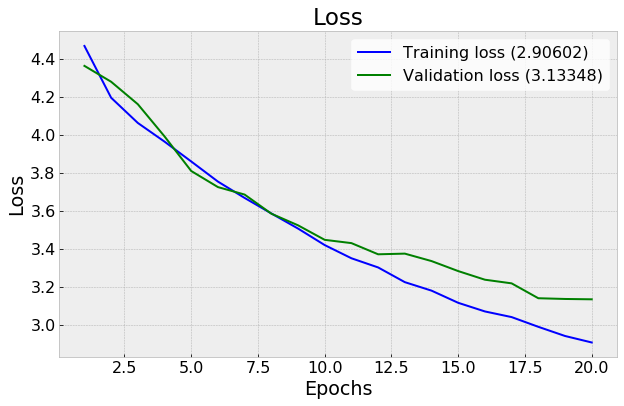

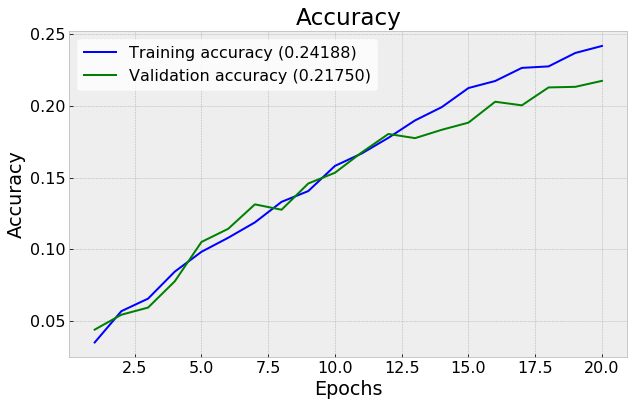

In [43]:
plot_history(history_wmfl, figsize=(10,6))

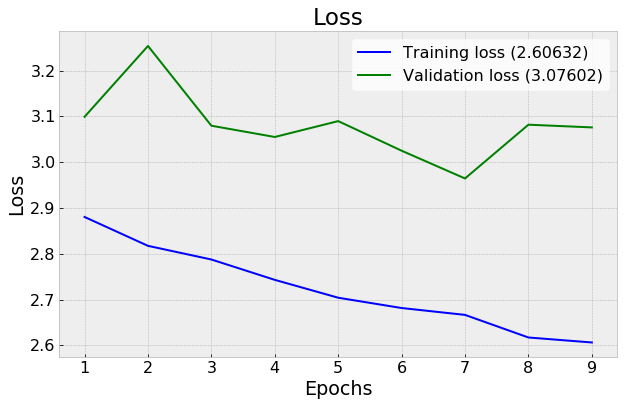

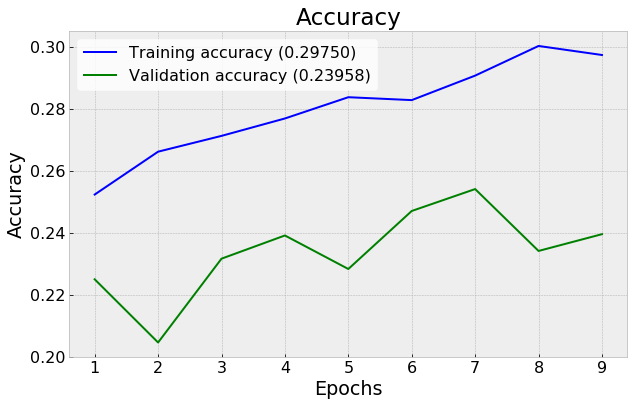

In [46]:
plot_history(history_wmfl_2, figsize=(10,6))

In [44]:
# let's continue training and see if we can improve accuracy and loss

wide_model_fast_learn.load_weights('saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5')

history_wmfl_2 = wide_model_fast_learn.fit_generator(train_generator, validation_data=validation_generator,
                         steps_per_epoch=800, epochs=20, callbacks=[checkpointer, early_stopping])

Epoch 1/20
800/800 [==============================] - 184s 231ms/step - loss: 2.8804 - acc: 0.2524 - val_loss: 3.0992 - val_acc: 0.2250

Epoch 00001: val_loss improved from 3.13348 to 3.09921, saving model to saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5
Epoch 2/20
800/800 [==============================] - 183s 229ms/step - loss: 2.8174 - acc: 0.2663 - val_loss: 3.2539 - val_acc: 0.2046

Epoch 00002: val_loss did not improve
Epoch 3/20
800/800 [==============================] - 184s 230ms/step - loss: 2.7875 - acc: 0.2714 - val_loss: 3.0797 - val_acc: 0.2317

Epoch 00003: val_loss improved from 3.09921 to 3.07970, saving model to saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5
Epoch 4/20
800/800 [==============================] - 187s 233ms/step - loss: 2.7431 - acc: 0.2770 - val_loss: 3.0551 - val_acc: 0.2392

Epoch 00004: val_loss improved from 3.07970 to 3.05509, saving model to saved_models/weights.bestaugmented.from_sc

In [121]:
wide_model_fast_learn.save('saved_models/wide_model_fast_learn.h5')

In [102]:
batch_size = 64

history_wmfl_3 = wide_model_fast_learn.fit_generator(train_generator, validation_data=validation_generator,
                         steps_per_epoch=150, epochs=10, callbacks=[checkpointer])

Epoch 1/10
150/150 [==============================] - 63s 419ms/step - loss: 2.5234 - acc: 0.3056 - val_loss: 2.9315 - val_acc: 0.2617

Epoch 00001: val_loss improved from 2.96450 to 2.93154, saving model to saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5
Epoch 2/10
150/150 [==============================] - 70s 468ms/step - loss: 2.5078 - acc: 0.3244 - val_loss: 3.0203 - val_acc: 0.2383

Epoch 00002: val_loss did not improve
Epoch 3/10
150/150 [==============================] - 72s 480ms/step - loss: 2.6184 - acc: 0.3017 - val_loss: 3.1779 - val_acc: 0.2113

Epoch 00003: val_loss did not improve
Epoch 4/10
150/150 [==============================] - 67s 448ms/step - loss: 2.5116 - acc: 0.3128 - val_loss: 3.0023 - val_acc: 0.2558

Epoch 00004: val_loss did not improve
Epoch 5/10
150/150 [==============================] - 63s 422ms/step - loss: 2.6213 - acc: 0.2967 - val_loss: 2.9524 - val_acc: 0.2471

Epoch 00005: val_loss did not improve
Epoch 6/10
150/150

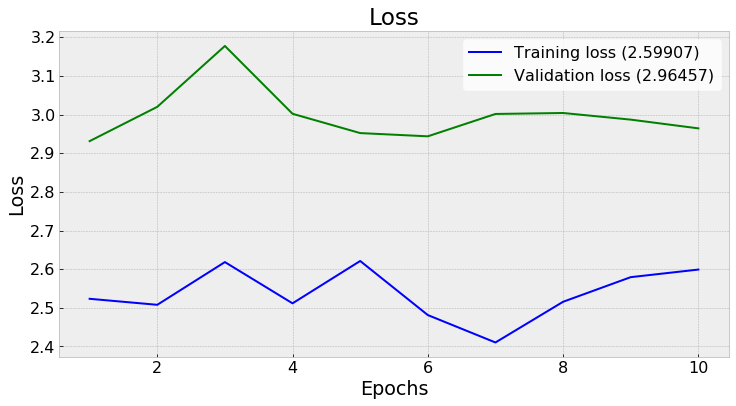

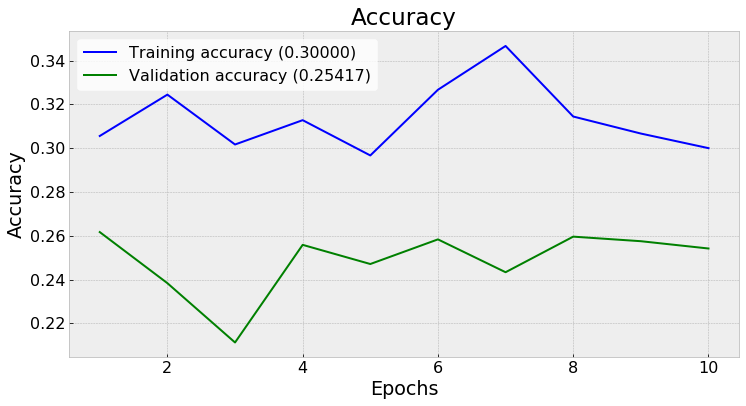

In [103]:
# appears this first model is going to top out in accuracy and bottom out in loss here... let's plot our progress so far

plot_history(history_wmfl_3, figsize=(12,6))

In [108]:
# trying new model with increase # of filters and "he_normal" kernel initializer.  "glorot_uniform" is default
# also adding dropout layer since it seems that our prior model experience overfitting 

new_model = Sequential()

new_model.add(BatchNormalization(input_shape=input_shape))
new_model.add(Conv2D(16, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(BatchNormalization())


new_model.add(Conv2D(32, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(BatchNormalization())

new_model.add(Conv2D(64, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(BatchNormalization())

new_model.add(Conv2D(128, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.4))
new_model.add(BatchNormalization())

new_model.add(Conv2D(256, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model.add(MaxPooling2D(pool_size=(2, 2)))
new_model.add(Dropout(0.4))
new_model.add(BatchNormalization())

new_model.add(GlobalAveragePooling2D())

new_model.add(Dense(num_classes, activation='softmax'))

new_model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(new_model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_14 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 54, 54, 32)        128       
__________

In [110]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch_saksham789.hdf5', 
                               verbose=1, save_best_only=True)

batch_size = 64

history = new_model.fit_generator(train_generator, validation_data=validation_generator,
                         steps_per_epoch=150, epochs=100, callbacks=[checkpointer])

Epoch 1/100
150/150 [==============================] - 47s 314ms/step - loss: 4.6348 - acc: 0.0217 - val_loss: 4.5933 - val_acc: 0.0308

Epoch 00001: val_loss improved from inf to 4.59334, saving model to saved_models/weights.bestaugmented.from_scratch_saksham789.hdf5
Epoch 2/100
150/150 [==============================] - 56s 376ms/step - loss: 4.4620 - acc: 0.0367 - val_loss: 4.4251 - val_acc: 0.0454

Epoch 00002: val_loss improved from 4.59334 to 4.42515, saving model to saved_models/weights.bestaugmented.from_scratch_saksham789.hdf5
Epoch 3/100
150/150 [==============================] - 60s 398ms/step - loss: 4.3320 - acc: 0.0450 - val_loss: 4.4658 - val_acc: 0.0496

Epoch 00003: val_loss did not improve
Epoch 4/100
150/150 [==============================] - 60s 402ms/step - loss: 4.3009 - acc: 0.0517 - val_loss: 4.2274 - val_acc: 0.0500

Epoch 00004: val_loss improved from 4.42515 to 4.22742, saving model to saved_models/weights.bestaugmented.from_scratch_saksham789.hdf5
Epoch 5/10

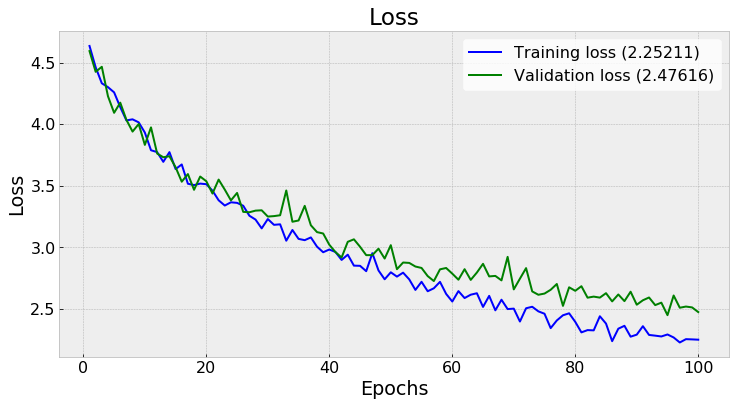

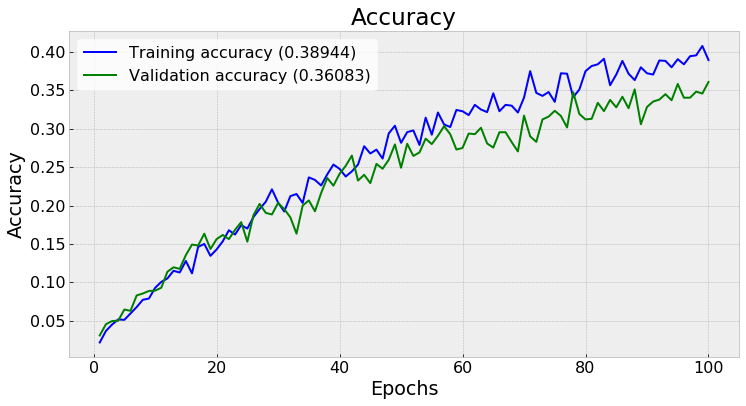

In [111]:
plot_history(history,figsize=(12,6))

In [112]:
new_model.save('saved_models/new_model.h5')

In [ ]:
# continue training?

In [117]:
# appears dropout might be too aggresive... 

new_model_2 = Sequential()

new_model_2.add(BatchNormalization(input_shape=input_shape))
new_model_2.add(Conv2D(16, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))
new_model_2.add(BatchNormalization())


new_model_2.add(Conv2D(32, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))
new_model_2.add(BatchNormalization())

new_model_2.add(Conv2D(64, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))
new_model_2.add(BatchNormalization())

new_model_2.add(Conv2D(128, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))
new_model_2.add(Dropout(0.2))
new_model_2.add(BatchNormalization())

new_model_2.add(Conv2D(256, (3, 3), strides=1, kernel_initializer='he_normal', activation='relu'))
new_model_2.add(MaxPooling2D(pool_size=(2, 2)))
new_model_2.add(Dropout(0.2))

new_model_2.add(GlobalAveragePooling2D())

new_model_2.add(Dense(num_classes, activation='softmax'))

new_model_2.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
print(new_model_2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_30 (Batc (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 222, 222, 16)      448       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 111, 111, 16)      0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 111, 111, 16)      64        
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 109, 109, 32)      4640      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 54, 54, 32)        0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 54, 54, 32)        128       
__________

In [118]:


batch_size = 64

checkpointer = ModelCheckpoint(filepath='saved_models/weights.bestaugmented.from_scratch_saksham789_v2.hdf5', 
                               verbose=1, save_best_only=True)

history = new_model_2.fit_generator(train_generator, validation_data=validation_generator,
                         steps_per_epoch=150, epochs=100, callbacks=[checkpointer])

Epoch 1/100
150/150 [==============================] - 60s 397ms/step - loss: 5.2180 - acc: 0.0233 - val_loss: 4.7432 - val_acc: 0.0379

Epoch 00001: val_loss improved from inf to 4.74325, saving model to saved_models/weights.bestaugmented.from_scratch_saksham789_v2.hdf5
Epoch 2/100
150/150 [==============================] - 60s 399ms/step - loss: 4.7469 - acc: 0.0267 - val_loss: 4.6883 - val_acc: 0.0313

Epoch 00002: val_loss improved from 4.74325 to 4.68830, saving model to saved_models/weights.bestaugmented.from_scratch_saksham789_v2.hdf5
Epoch 3/100
150/150 [==============================] - 60s 403ms/step - loss: 4.5890 - acc: 0.0333 - val_loss: 4.5373 - val_acc: 0.0283

Epoch 00003: val_loss improved from 4.68830 to 4.53727, saving model to saved_models/weights.bestaugmented.from_scratch_saksham789_v2.hdf5
Epoch 4/100
150/150 [==============================] - 60s 402ms/step - loss: 4.4759 - acc: 0.0456 - val_loss: 4.4513 - val_acc: 0.0475

Epoch 00004: val_loss improved from 4.5

In [119]:
new_model_2.save('saved_models/new_model_2.5')

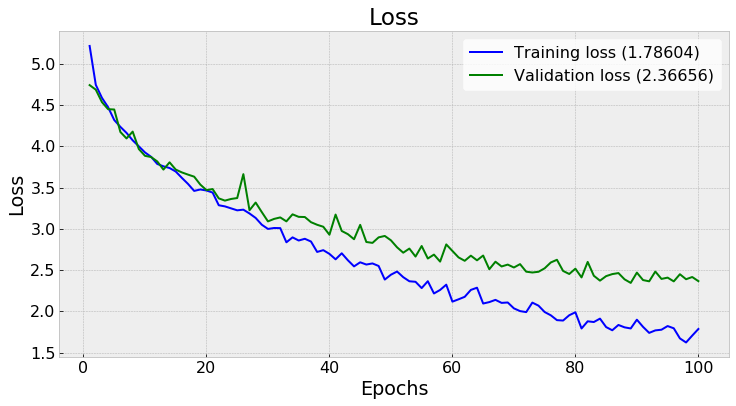

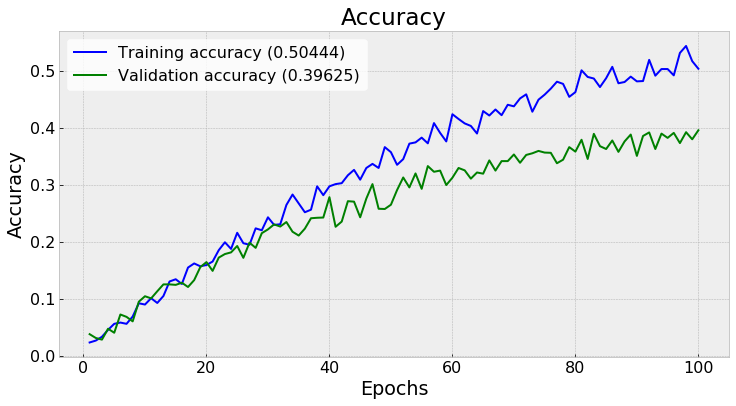

In [120]:
plot_history(history, figsize=(12,6))

Looks like a slight improvement with a smaller dropout rate. Let's move on to using a pre-trained model and see if we can improve for additional training.... 

For now, let's make predictions, plot and analyze model performance for both this model and  the prior (wide model fast learn).

In [15]:
# load the first model

from keras.models import load_model

model = load_model('saved_models/wide_model_fast_learn.h5')
model.load_weights('saved_models/weights.bestaugmented.from_scratch_wide_model_fast_learn_v2.hdf5')

In [39]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [41]:
validation_encoded_labels = le.fit_transform(valid_labels)

In [36]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title='Normalized confusion matrix'
    else:
        title='Confusion matrix'

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
## multiclass or binary report
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size=32,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=5))    
    
    # 5. Plot confusion matrix
    cnf_matrix = confusion_matrix(y_true,y_pred)
    print(cnf_matrix)
    plot_confusion_matrix(cnf_matrix,classes=classes)